# DNA Sequencing with Machine Learning 

In this notebook, I will apply a classification model that can predict a gene's function based on the DNA sequence of the coding sequence alone.

# Setting up environment and importing packages

In [5]:
import requests as rq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# download datasets
chimp_data_url = 'https://raw.githubusercontent.com/callezenwaka/DNA-Sequence-Classifier/main/chimp_data.txt'
r = rq.get(chimp_data_url)
with open('chimp_data.txt', 'w') as f:
    f.write(r.text)

dog_data_url = 'https://raw.githubusercontent.com/callezenwaka/DNA-Sequence-Classifier/main/dog_data.txt'
r = rq.get(chimp_data_url)
with open('dog_data.txt', 'w') as f:
    f.write(r.text)

human_data_url = 'https://raw.githubusercontent.com/callezenwaka/DNA-Sequence-Classifier/main/human_data.txt'
r = rq.get(human_data_url)
with open('human_data.txt', 'w') as f:
    f.write(r.text)

In [7]:
# read human dataset and output sample
human_data = pd.read_table('human_data.txt')
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


We have some data for human DNA sequence coding regions and a class label. We also have data for Chimpanzee and a more divergent species, the dog.

In [8]:
# read chimp and dog datasets
chimp_data = pd.read_table('chimp_data.txt')
dog_data = pd.read_table('dog_data.txt')
chimp_data.head()
dog_data.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


Here are the definitions for each of the 7 classes and how many there are in the human training data. They are gene sequence function groups.

![Gene_sequence_function_groups](https://raw.githubusercontent.com/callezenwaka/DNA-Sequence-Classifier/main/Gene_sequence_function_groups.jpg)

**Treating DNA sequence as a "language", otherwise known as k-mer counting**

A challenge that remains is that none of these above methods results in vectors of uniform length, and that is a requirement for feeding data to a classification or regression algorithm. So with the above methods you have to resort to things like truncating sequences or padding with "n" or "0" to get vectors of uniform length.

DNA and protein sequences can be viewed metaphorically as the language of life. The language encodes instructions as well as function for the molecules that are found in all life forms. The sequence language analogy continues with the genome as the book, subsequences (genes and gene families) are sentences and chapters, k-mers and peptides (motifs) are words, and nucleotide bases and amino acids are the alphabet. Since the analogy seems so apt, it stands to reason that the amazing work done in the natural language processing field should also apply to the natural language of DNA and protein sequences.

The method I use here is simple and easy. I first take the long biological sequence and break it down into k-mer length overlapping “words”. For example, if I use "words" of length 6 (hexamers), “ATGCATGCA” becomes: ‘ATGCAT’, ‘TGCATG’, ‘GCATGC’, ‘CATGCA’. Hence our example sequence is broken down into 4 hexamer words.

Here I am using hexamer “words” but that is arbitrary and word length can be tuned to suit the particular situation. The word length and amount of overlap need to be determined empirically for any given application.

In genomics, we refer to these types of manipulations as "k-mer counting", or counting the occurances of each possible k-mer sequence. There are specialized tools for this, but the Python natural language processing tools make it super easy.

Here is a function that can be used to convert any sequence (string) to overlapping k-mer words:

In [9]:
# convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [10]:
# convert training data sequences into short overlapping k-mers of legth 6
human_data['words'] = human_data.apply(lambda x: getKmers(x['sequence']), axis=1)
human_data = human_data.drop('sequence', axis=1)
chimp_data['words'] = chimp_data.apply(lambda x: getKmers(x['sequence']), axis=1)
chimp_data = chimp_data.drop('sequence', axis=1)
dog_data['words'] = dog_data.apply(lambda x: getKmers(x['sequence']), axis=1)
dog_data = dog_data.drop('sequence', axis=1)

In [11]:
# preview possible k-mer words
human_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


In [12]:
# convert the human lists of k-mers for each gene into string sentences of words
human_texts = list(human_data['words'])
for item in range(len(human_texts)):
  human_texts[item] = ' '.join(human_texts[item])

# define cluster label
y_human = human_data.iloc[:, 0].values
print(f"y_human:\n{y_human}\n")
print(f"human_texts[2]:\n{human_texts[2]}")

y_human:
[4 4 3 ... 6 6 6]

human_texts[2]:
atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggcatt gcattt catttg atttgg tttggg ttgggc tgggcg gggcgc ggcgct gcgctg cgctgt gctgtt ctgttt tgtttg gtttgg tttggc ttggca tggcag ggcagt gcagtg cagtga agtgat gtgatg tgatga gatgat atgatt tgattg gattgc attgcc ttgcct tgcctt gccttt cctttc ctttct tttctg ttctgt tctgtt ctgttc tgttca gttcag ttcagt tcagtg cagtgt agtgtc gtgtct tgtctg gtctga tctgag ctgagt tgagtg gagtgc agtgct gtgcta tgctat gctatg ctatga tatgaa atgaag tgaaga gaagat aagatt agattg gattgc attgca ttgcac tgcaca gcacac cacaca acacag cacaga acagag cagagg agaggt gaggtc aggtcc ggtcca gtccag tccaga ccagat cagatg agatgc gatgca atgcat tgcatt gcattc cattcc attccg ttccgt tccgtt ccgttt cgtttt gttttg ttttga tttgag ttgaga tgagaa gagaat agaatg gaatgt aatgtc atgtca tgtcaa gtcaat tcaatg caatgg aatgga atggat tggata ggatac gataca atacac tacacc acacca caccaa accaac ccaact caactg aactgc actgct ctgctg tgctgc gctgct ctgctt tgcttt gctttg ctttgg tttgga ttggat tggatt ggattt gatt

In [15]:
# convert the chimp lists of k-mers for each gene into string sentences of words
chimp_texts = list(chimp_data['words'])
for item in range(len(chimp_texts)):
  chimp_texts[item] = ' '.join(chimp_texts[item])

# define cluster label
y_chimp = chimp_data.iloc[:, 0].values

In [16]:
# convert the dog lists of k-mers for each gene into string sentences of words
dog_texts = list(dog_data['words'])
for item in range(len(dog_texts)):
  dog_texts[item] = ' '.join(dog_texts[item])

# define cluster label
y_dog = dog_data.iloc[:, 0].values

Apply bag of words using NLG CountVectorizer

In [17]:
# performing k-mer counting
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X_human = cv.fit_transform(human_texts)
X_chimp = cv.fit_transform(chimp_texts)
X_dog = cv.fit_transform(dog_texts)
print(f"X_human shape: {X_human.shape}\nX_chimp shape: {X_chimp.shape}\nX_dog shape: {X_dog.shape}\n")

X_human shape: (4380, 232414)
X_chimp shape: (1682, 229684)
X_dog shape: (1682, 229684)



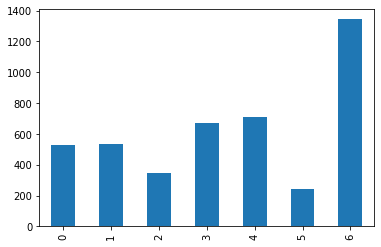

In [18]:
# preview class balance
human_data['class'].value_counts().sort_index().plot.bar()

In [19]:
# split the human dataset into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_human, y_human, test_size = 0.20, random_state=42)
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")

X_train: (3504, 232414)
X_test: (876, 232414)


In [20]:
# define multinomial Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [21]:
# classify and run prediction
y_pred = classifier.predict(X_test)

In [23]:
# model performance
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print(f"Confusion matrix:\n{pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted'))}")
def get_metrics(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')
  return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print(f"accuracy: {accuracy:.3f}\nprecision: {precision:.3f}\nrecall: {recall:.3f}\nf1: {f1:.3f}")

Confusion matrix:
Predicted   0    1   2    3    4   5    6
Actual                                   
0          99    0   0    0    1   0    2
1           0  104   0    0    0   0    2
2           0    0  78    0    0   0    0
3           0    0   0  124    0   0    1
4           1    0   0    0  143   0    5
5           0    0   0    0    0  51    0
6           1    0   0    1    0   0  263
accuracy: 0.984
precision: 0.984
recall: 0.984
f1: 0.984
